# Head

In [1]:
import numpy as np
import pandas as pd
import time
import serial
from matplotlib import pyplot as plt

In [2]:
# from tensorflow.keras.utils import to_categorical
from comet_ml import Experiment

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, learning_curve, StratifiedKFold, LearningCurveDisplay
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay

from statsmodels.tsa.seasonal import seasonal_decompose

from IPython.display import clear_output

# Optuna
import optuna

In [3]:
palm_file = './data/2023-05-31_17-14-41.palm'
model_name = None # LogisticRegression
model = LogisticRegression(max_iter=1000,C=1)
OFFSET = 20 # Смещение
# comet.ml data
API_KEY = ''
PROJECT_NAME = ''
WORKSPACE = ''
# do list
DO_DRAW_PLOTS = True # Построение графиков
DO_HYPEROPT = False # Поиск гиперпараметров hyperopt
DO_MMSCALER = True # Скалирование данных
DO_PLOT_LEARNING_CURVE = False # Нарисовать график кривой обучения
DO_OFFLINE_INFERENCE = True # Оффлайн проверка инференса
DO_ONLINE_INFERENCE = True # Онлайн проверка инференса
DO_LOG = False # Логирование 

DO_REPLACE_TO_MOVING_AVERAGE = True # Заменяем на скользящее среднее

In [4]:
try: print_report() 
except: pass

# IO utils


In [5]:
def read_omg_csv(path_palm_data: str, 
                 n_omg_channels: int, 
                 n_acc_channels: int = 0, 
                 n_gyr_channels: int = 0, 
                 n_mag_channels: int = 0, 
                 n_enc_channels: int = 0,
                 button_ch: bool = True, 
                 sync_ch: bool = True, 
                 timestamp_ch: bool = True) -> pd.DataFrame:
    
    '''
    Reads CSV data for OMG data
    NB: data must be separated by " " separator

        Parameters:
                path_palm_data  (str): path to csv data file
                n_omg_channels  (int): Number of OMG channels
                n_acc_channels  (int): Number of Accelerometer channels, default = 0
                n_gyr_channels  (int): Number of Gyroscope channels, default = 0
                n_mag_channels  (int): Number of Magnetometer channels, default = 0
                n_enc_channels  (int): Number of Encoder channels, default = 0
                button_ch      (bool): If button channel is present, default = True
                sync_ch        (bool): If synchronization channel is present, default = True
                timestamp_ch   (bool): If timestamp channel is present, default = True

        Returns:
                df_raw (pd.DataFrame): Parsed pandas Dataframe with OMG data
    '''
    
    df_raw = pd.read_csv(path_palm_data, sep=' ', 
                         header=None, 
                         skipfooter=1, 
                         skiprows=1, 
                         engine='python')
    columns = np.arange(n_omg_channels).astype('str').tolist()
    
    for label, label_count in zip(['ACC', 'GYR', 'MAG', 'ENC'], 
                                  [n_acc_channels, n_gyr_channels, n_mag_channels, n_enc_channels]):
        columns = columns + ['{}{}'.format(label, i) for i in range(label_count)]
        
    if button_ch:
        columns = columns + ['BUTTON']
        
    if sync_ch:
        columns = columns + ['SYNC']
        
    if timestamp_ch:
        columns = columns + ['ts']
        
    df_raw.columns = columns
    
    return df_raw

In [6]:
def print_report():
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    print('='*25,'Train','='*25)
    print(classification_report(y_train, y_pred_train, target_names=GESTURES))
    print('='*25,'Test','='*25)
    print(classification_report(y_test, y_pred_test, target_names=GESTURES))

# Abbreviations
OMG — optomiography  
ACC — accelerometer  
GYR — gyroscope  
ENC - encoders (fingers of prosthesis or gloves)  
model — model of data  

# Data

In [7]:
gestures = read_omg_csv(palm_file, 
                              n_omg_channels=50,
                              n_acc_channels=3, 
                              n_gyr_channels=3, 
                              n_enc_channels=6, 
                              n_mag_channels=0)

print(gestures.shape) 
gestures.head()

(19568, 65)


,0,1,2,3,4,5,6,7,8,9,...,GYR2,ENC0,ENC1,ENC2,ENC3,ENC4,ENC5,BUTTON,SYNC,ts
0,12,8,5,6,2,4,5,7,14,8,...,-13,0,0,0,0,0,0,0,0,555777
1,13,8,4,5,3,0,5,4,9,10,...,-16,0,0,0,0,0,0,0,0,555810
2,12,5,9,5,0,0,6,5,10,9,...,-14,0,0,0,0,0,0,0,0,555843
3,10,7,6,4,1,0,4,6,7,8,...,-12,0,0,0,0,0,0,0,0,555876
4,12,6,6,7,3,2,6,7,9,12,...,-12,0,0,0,0,0,0,0,0,555909


In [8]:
# [X features] '0', ..., '49' - каналы OMG датчиков
#              'ACC0', 'ACC1', 'ACC2' - акселерометр (потенциально могут использоваться как факторы для модели)
#              'GYR0', 'GYR1', 'GYR2' - гироскоп     (потенциально могут использоваться как факторы для модели)
# 'BUTTON' - не используется
# 'SYNC' - синхронизация данных с протоколом
# 'ts' - метка времени
gestures.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', 'ACC0', 'ACC1', 'ACC2', 'GYR0', 'GYR1', 'GYR2', 'ENC0', 'ENC1',
       'ENC2', 'ENC3', 'ENC4', 'ENC5', 'BUTTON', 'SYNC', 'ts'],
      dtype='object')

In [9]:
# Списки с названиями признаков
OMG_CH = [str(i) for i in range(50)]

ACC_CH = ['ACC0', 'ACC1', 'ACC2']
GYR_CH = ['GYR0', 'GYR1', 'GYR2']
ALL_CH = OMG_CH + ACC_CH + GYR_CH

ENC_CH = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
BUTTON_SYNC_TS_CH = ['BUTTON', 'SYNC', 'ts']
# Проверка что списки нужной длины
assert len(OMG_CH)+len(ACC_CH)+len(GYR_CH)+len(ENC_CH)+len(BUTTON_SYNC_TS_CH) == gestures.shape[-1]

print(f"OMG_CH: {list(OMG_CH)}")
print(f"ACC_CH: {list(ACC_CH)}")
print(f"GYR_CH: {list(GYR_CH)}")
print(f"ENC_CH: {list(ENC_CH)}")
print(f"BUTTON_SYNC_TS_CH: {list(BUTTON_SYNC_TS_CH)}")

OMG_CH: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49']
ACC_CH: ['ACC0', 'ACC1', 'ACC2']
GYR_CH: ['GYR0', 'GYR1', 'GYR2']
ENC_CH: ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
BUTTON_SYNC_TS_CH: ['BUTTON', 'SYNC', 'ts']


### OMG_CH

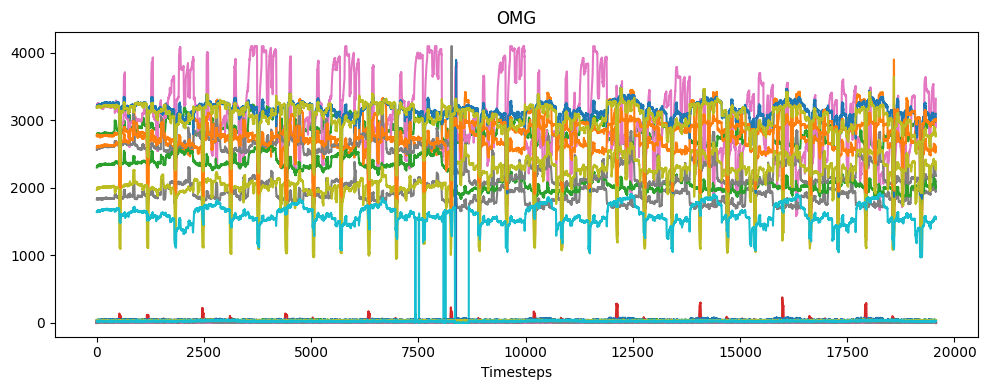

In [10]:
if DO_DRAW_PLOTS:
    # График показаний датчиков
    fig = plt.figure(figsize=(10, 4))
    plt.plot(gestures[OMG_CH].values)
    plt.title('OMG')
    plt.xlabel('Timesteps')
    plt.tight_layout()

### ACC GYR

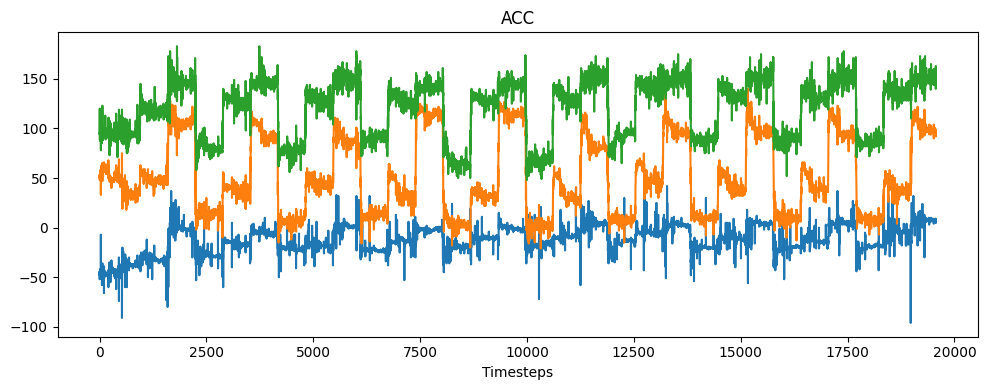

In [11]:
if DO_DRAW_PLOTS:
    # График показаний акселерометров
    fig = plt.figure(figsize=(10, 4))
    plt.plot(gestures[ACC_CH].values)
    plt.title('ACC')
    plt.xlabel('Timesteps')
    plt.tight_layout()

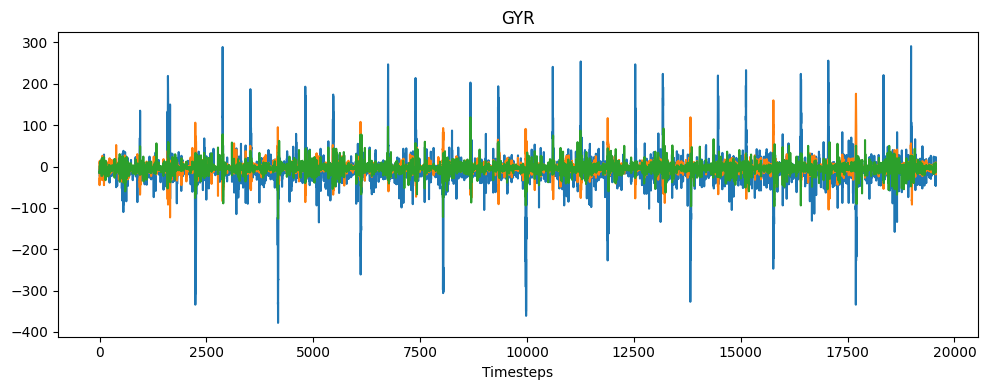

In [12]:
if DO_DRAW_PLOTS:
    # График показаний акселерометров
    fig = plt.figure(figsize=(10, 4))
    plt.plot(gestures[GYR_CH].values)
    plt.title('GYR')
    plt.xlabel('Timesteps')
    plt.tight_layout()

### Protocol

In [13]:
# Целевые признаки сгибаний и разгибаний пальцев руки
gestures_protocol = pd.read_csv(f'{palm_file}.protocol.csv', index_col=0)
gestures_protocol

,Thumb,Index,Middle,Ring,Pinky,Thumb_stretch,Index_stretch,Middle_stretch,Ring_stretch,Pinky_stretch,Pronation
epoch,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
176,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
177,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
178,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0


In [14]:
# Перекодируем 10 признаков в 1 целевой признак 
le = LabelEncoder()

# FIT
le.fit(
    gestures_protocol[[
        #'Pronation',
        "Thumb","Index","Middle","Ring","Pinky",
        'Thumb_stretch','Index_stretch','Middle_stretch','Ring_stretch','Pinky_stretch',
    ]]
    .apply(lambda row: str(tuple(row)), axis=1)
)
# TRANSFORM
gestures_protocol['gesture'] = le.transform(
    gestures_protocol[[
        #'Pronation',
        "Thumb","Index","Middle","Ring","Pinky",
        'Thumb_stretch','Index_stretch','Middle_stretch','Ring_stretch','Pinky_stretch',
    ]]
    .apply(lambda row: str(tuple(row)), axis=1)
)
# Оказалось только 6 уникальных комбинаций сгибаний и растягиваний пальцев
display(np.c_[le.transform(le.classes_), le.classes_])

array([[0, '(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [1, '(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0)'],
       [2, '(0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [3, '(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [4, '(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [5, '(1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)']],
      dtype=object)

In [15]:
GESTURES = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']
GESTURES

['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

In [16]:
# Жесты в разные эпохи, 1 эпоха = 1 жест
gestures_protocol['gesture']

epoch
0      0
1      0
2      3
3      5
4      1
      ..
176    3
177    5
178    1
179    4
180    2
Name: gesture, Length: 181, dtype: int32

In [17]:
# Расширенный целевой признак
y_cmd = np.array([gestures_protocol['gesture'].loc[s] for s in gestures['SYNC'].values])
print(y_cmd.shape)
y_cmd

(19568,)


array([0, 0, 0, ..., 0, 0, 0])

In [18]:
# Расширенный признак поворота руки
y_pronation = np.array([gestures_protocol['Pronation'].loc[s] for s in gestures['SYNC'].values])
print(y_pronation.shape)
y_pronation

(19568,)


array([0., 0., 0., ..., 0., 0., 0.])

# Data preprocessing

## OMG_CH

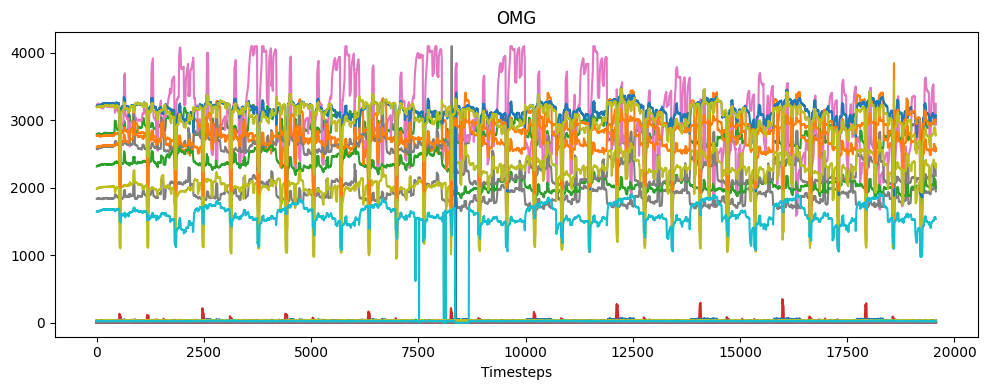

In [19]:
if DO_REPLACE_TO_MOVING_AVERAGE: # Замена на скользящее среднее
    for col in OMG_CH:
        #производим декомпозицию временного ряда 
        gestures[col] = gestures[col].rolling(window=5).mean().bfill()
        
    if DO_DRAW_PLOTS:
        # График показаний датчиков после изменений
        fig = plt.figure(figsize=(10, 4))
        plt.plot(gestures[OMG_CH].values)
        plt.title('OMG')
        plt.xlabel('Timesteps')
        plt.tight_layout()

### OMG_DERIV

In [20]:
# Производная показаний датчиков
OMG_NEXT = [str(i)+'_next' for i in range(50)]
for col in OMG_CH:
    gestures[f'{col}_next'] = gestures[col].shift().bfill()
    
OMG_DERIV = [str(i)+'_deriv' for i in range(50)]
for col in OMG_CH:
    gestures[f'{col}_deriv'] = gestures[f'{col}_next'] - gestures[col]
gestures = gestures.copy()

C:\Users\Олег\AppData\Local\Temp\ipykernel_3324\558391599.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  gestures[f'{col}_next'] = gestures[col].shift().bfill()
C:\Users\Олег\AppData\Local\Temp\ipykernel_3324\558391599.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  gestures[f'{col}_deriv'] = gestures[f'{col}_next'] - gestures[col]
C:\Users\Олег\AppData\Local\Temp\ipykernel_3324\558391599.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has

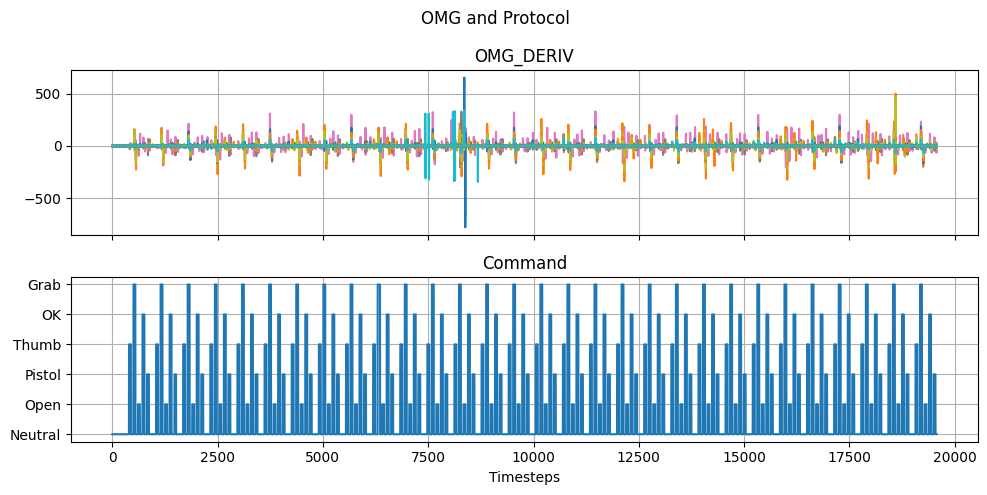

In [21]:
# График показаний датчиков
fig, axx = plt.subplots(2, 1, sharex=True, figsize=(10, 5))
plt.sca(axx[0])
plt.plot(gestures[OMG_DERIV].values)
plt.grid()
plt.title('OMG_DERIV')
  
plt.sca(axx[1])
plt.plot(y_cmd)
plt.grid()
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.title('Command')
plt.xlabel('Timesteps')
    
plt.suptitle('OMG and Protocol')
plt.tight_layout()

## Protocol

In [22]:
# Смещение целевого признака
id_max = 0
cur_gesture = 0
for i in range(y_cmd.shape[0]):
    if i < id_max: # Пропускаем все значения до id_max
        continue
    prev_gesture = cur_gesture # предыдущий жест
    cur_gesture = y_cmd[i] # текущий жест
    if cur_gesture != prev_gesture: # Если сменился жест то ищем в данных спереди максимальный скачок
        id_max = gestures[OMG_DERIV][i:i+35].abs().sum(axis=1).idxmax() # модуль производных -> сумма всех датчиков -> айди максимального значения
        y_cmd[i:id_max] = prev_gesture # Заменяем все значения до id_max на предыдущий жест

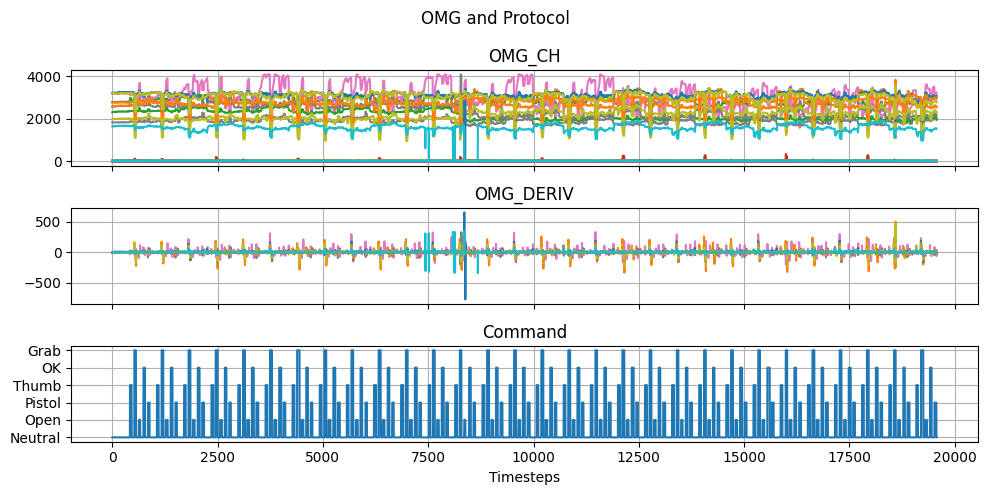

In [23]:
if DO_DRAW_PLOTS: # После смещения
    # График показаний датчиков
    fig, axx = plt.subplots(3, 1, sharex=True, figsize=(10, 5))
    
    plt.sca(axx[0])
    plt.plot(gestures[OMG_CH].values)
    plt.grid()
    plt.title('OMG_CH')
    
    plt.sca(axx[1])
    plt.plot(gestures[OMG_DERIV].values)
    plt.grid()
    plt.title('OMG_DERIV')
    
    plt.sca(axx[2])
    plt.plot(y_cmd)
    plt.grid()
    plt.yticks(np.arange(len(GESTURES)), GESTURES)
    plt.title('Command')
    plt.xlabel('Timesteps')
        
    plt.suptitle('OMG and Protocol')
    plt.tight_layout()

# Train-test split

In [24]:
df_meta = pd.read_csv('./data/meta_information.csv', index_col=0)
df_meta.head()

,montage,pilote_id,last_train_idx,len(train),len(test)
0,2023-05-15_16-16-08.palm,1,23337,23337,5810
1,2023-05-15_17-12-24.palm,1,23336,23336,5803
2,2023-06-05_16-12-38.palm,1,17939,17939,4431
3,2023-06-05_17-53-01.palm,1,17771,17771,4435
4,2023-06-20_14-43-11.palm,1,17936,17936,4441


In [25]:
# Узнаем последний индекс обучающей выборки для нужного файла
last_train_idx = df_meta[df_meta['montage'] == palm_file.split('/')[-1]].to_dict(orient='records')[0]['last_train_idx']
last_train_idx

15679

In [26]:
# Разделяем данные на обучающую и тестовую по индексу полученному с /data/meta_information.csv
X_train = gestures[ALL_CH].values[:last_train_idx]
y_train = y_cmd[:last_train_idx]

X_test = gestures[ALL_CH].values[last_train_idx:]
y_test = y_cmd[last_train_idx:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(15679, 56) (15679,)
(3889, 56) (3889,)


# Modeling

In [27]:
DO_MMSCALER = True
if DO_MMSCALER:
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

## Logreg

In [28]:
#Создаём объект класса LogisticRegression
log_reg = LogisticRegression(
    multi_class='multinomial', #мультиклассовая классификация
    max_iter=1000, #количество итераций, выделенных на сходимость
    random_state=42 #генерация случайных чисел
)
#Обучаем модель
log_reg.fit(X_train, y_train)
#Делаем предсказание класса
y_pred = log_reg.predict(X_test)

print(f'Метрики на валидационной выборке \n\
{classification_report(y_test, y_pred)}')

Метрики на валидационной выборке 
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      2607
           1       0.98      0.90      0.94       246
           2       0.94      0.98      0.96       280
           3       0.82      0.56      0.66       252
           4       0.79      0.95      0.86       246
           5       0.93      0.88      0.91       258

    accuracy                           0.93      3889
   macro avg       0.90      0.87      0.88      3889
weighted avg       0.93      0.93      0.93      3889



In [29]:
# Пустой словарь, в который будем заносить показатели метрики
mean_f1 = {}
# Заносим в него первое значение
mean_f1['LogReg'] = [
    round(f1_score(y_test, y_pred, average = 'micro'), 3)
    ]

In [30]:
def optuna_lr(trial):
  # задаем пространства поиска гиперпараметров
  penalty = trial.suggest_categorical('penalty', ('l1', 'l2'))
  solver = trial.suggest_categorical('solver', ('liblinear', 'saga'))
  C = trial.suggest_float(name='C', low=0.01, high=1, step=0.01)

  # создаем модель
  model = LogisticRegression(
        penalty=penalty,
        solver=solver,
        C=C,
        random_state=42,
        multi_class='auto'
    )
  
  # обучаем модель
  model.fit(X_train, y_train)
  score = f1_score(
    y_test, 
    model.predict(X_test), 
    average = 'micro'
    )

  return score

# cоздаем объект исследования
study_lr = optuna.create_study(study_name="LogisticRegression", direction="maximize")
# ищем лучшую комбинацию гиперпараметров:
study_lr.optimize(optuna_lr, n_trials=50)
# Выводим на экран гиперпараметры:
print(f'Наилучшие значения гиперпараметров: {study_lr.best_params}')

[I 2024-05-04 14:46:20,779] A new study created in memory with name: LogisticRegression
[I 2024-05-04 14:46:22,830] Trial 0 finished with value: 0.9033170480843404 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.35000000000000003}. Best is trial 0 with value: 0.9033170480843404.
[I 2024-05-04 14:46:24,463] Trial 1 finished with value: 0.9033170480843404 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 0.23}. Best is trial 0 with value: 0.9033170480843404.
[I 2024-05-04 14:47:24,697] Trial 2 finished with value: 0.9241450244278735 and parameters: {'penalty': 'l1', 'solver': 'liblinear', 'C': 0.6900000000000001}. Best is trial 2 with value: 0.9241450244278735.
c:\Users\Олег\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2024-05-04 14:47:29,544] Trial 3 finished with value: 0.9295448701465673 and parameters: {'pen

Наилучшие значения гиперпараметров: {'penalty': 'l1', 'solver': 'saga', 'C': 0.43}


In [31]:
log_reg_hyper = LogisticRegression(
    **study_lr.best_params,
    multi_class='auto', #мультиклассовая классификация
    random_state=42 #генерация случайных чисел
)
#Обучаем модель
log_reg_hyper.fit(X_train, y_train)
#Делаем предсказание класса
y_pred = log_reg_hyper.predict(X_test)

print(f'Метрики на валидационной выборке \n\
{classification_report(y_test, y_pred)}')

Метрики на валидационной выборке 
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      2607
           1       0.98      0.91      0.95       246
           2       0.92      0.99      0.96       280
           3       0.86      0.69      0.77       252
           4       0.83      0.95      0.88       246
           5       0.95      0.87      0.91       258

    accuracy                           0.94      3889
   macro avg       0.92      0.90      0.90      3889
weighted avg       0.94      0.94      0.94      3889



c:\Users\Олег\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [32]:
mean_f1['LogReg'].append(round(f1_score(y_test, y_pred, average = 'micro'), 3))

In [33]:
# Функция для рисования матрицы ошибок:
def drow_confusion_matrix(model):
    predictions = model.predict(X_test)
    cm = confusion_matrix(y_test, predictions, labels=model.classes_)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=model.classes_
    )
    disp.plot();

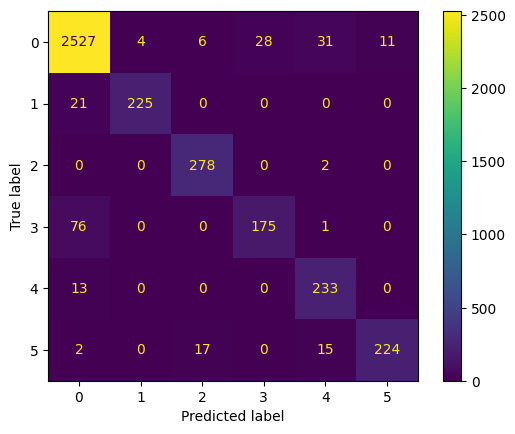

In [34]:
drow_confusion_matrix(log_reg_hyper)

## Деревья решений

In [36]:
from sklearn import tree

#Создаём объект класса DecisionTreeClassifier
dt = tree.DecisionTreeClassifier(random_state=42)
#Обучаем дерево решений по алгоритму CART
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

print(f'Метрики на валидационной выборке \n\
{classification_report(y_test, y_pred)}')

Метрики на валидационной выборке 
              precision    recall  f1-score   support

           0       0.89      0.84      0.86      2607
           1       0.94      0.93      0.93       246
           2       0.68      0.83      0.75       280
           3       0.34      0.31      0.32       252
           4       0.40      0.63      0.49       246
           5       0.94      0.91      0.93       258

    accuracy                           0.80      3889
   macro avg       0.70      0.74      0.71      3889
weighted avg       0.82      0.80      0.81      3889



In [37]:
mean_f1['DesTree'] = [
    round(f1_score(y_test, y_pred, average = 'micro'), 3)
    ]

In [38]:
def optuna_dt(trial):
  # задаем пространства поиска гиперпараметров
  criterion = trial.suggest_categorical('criterion', ('gini', 'entropy', 'log_loss'))
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
  
  # создаем модель
  model = tree.DecisionTreeClassifier(
    criterion=criterion,
    max_depth=max_depth,
    min_samples_leaf=min_samples_leaf,
    random_state=42
  )
  
  # обучаем модель
  model.fit(X_train, y_train)
  score = f1_score(
    y_test, 
    model.predict(X_test), 
    average = 'micro'
  )
  
  return score

# cоздаем объект исследования
study_dt = optuna.create_study(study_name="DecisionTreeClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров:
study_dt.optimize(optuna_dt, n_trials=50)
# Выводим на экран гиперпараметры:
print(f'Наилучшие значения гиперпараметров: {study_dt.best_params}')

[I 2024-05-04 15:02:36,701] A new study created in memory with name: DecisionTreeClassifier
[I 2024-05-04 15:02:38,244] Trial 0 finished with value: 0.869632296220108 and parameters: {'criterion': 'gini', 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.869632296220108.
[I 2024-05-04 15:02:39,091] Trial 1 finished with value: 0.870146567240936 and parameters: {'criterion': 'entropy', 'max_depth': 17, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.870146567240936.
[I 2024-05-04 15:02:40,084] Trial 2 finished with value: 0.8485471843661611 and parameters: {'criterion': 'log_loss', 'max_depth': 24, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.870146567240936.
[I 2024-05-04 15:02:40,919] Trial 3 finished with value: 0.868860889688866 and parameters: {'criterion': 'log_loss', 'max_depth': 20, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.870146567240936.
[I 2024-05-04 15:02:41,715] Trial 4 finished with value: 0.8516328104911288 and parameters: 

Наилучшие значения гиперпараметров: {'criterion': 'gini', 'max_depth': 12, 'min_samples_leaf': 6}


In [39]:
dtc_hyper = tree.DecisionTreeClassifier(
    **study_dt.best_params,
    random_state=42 #генерация случайных чисел
)
#Обучаем модель
dtc_hyper.fit(X_train, y_train)
#Делаем предсказание класса
y_pred = dtc_hyper.predict(X_test)

print(f'Метрики на валидационной выборке \n\
{classification_report(y_test, y_pred)}')

Метрики на валидационной выборке 
              precision    recall  f1-score   support

           0       0.92      0.95      0.93      2607
           1       0.98      0.93      0.96       246
           2       0.87      0.77      0.82       280
           3       0.44      0.27      0.34       252
           4       0.75      0.94      0.83       246
           5       0.93      0.92      0.93       258

    accuracy                           0.89      3889
   macro avg       0.82      0.80      0.80      3889
weighted avg       0.88      0.89      0.88      3889



In [41]:
mean_f1['DesTree'].append(round(f1_score(y_test, y_pred, average = 'micro'), 3))

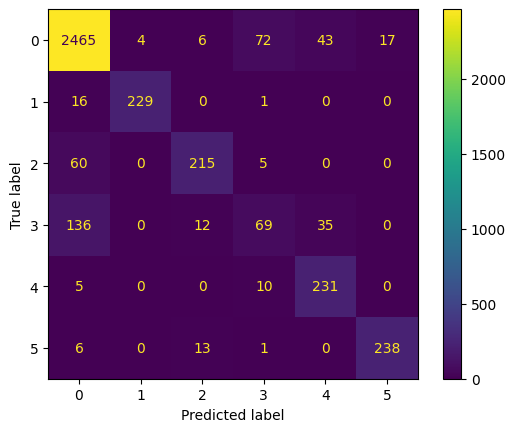

In [42]:
drow_confusion_matrix(dtc_hyper)

## Деревья решений + BaggingClassifier

In [43]:
from sklearn.ensemble import BaggingClassifier

bc = BaggingClassifier(dtc_hyper, random_state=42)
bc.fit(X_train, y_train)

y_pred = bc.predict(X_test)

print(f'Метрики на тестовой выборке \n\
{classification_report(y_test, y_pred)}')

Метрики на тестовой выборке 
              precision    recall  f1-score   support

           0       0.95      0.89      0.92      2607
           1       0.67      0.88      0.76       246
           2       0.73      0.96      0.83       280
           3       0.66      0.61      0.64       252
           4       0.79      0.93      0.86       246
           5       0.97      0.94      0.95       258

    accuracy                           0.88      3889
   macro avg       0.80      0.87      0.83      3889
weighted avg       0.89      0.88      0.88      3889



In [44]:
mean_f1['DesTree + bc'] = [
    round(f1_score(y_test, y_pred, average = 'micro'), 3)
    ]

In [45]:
def optuna_bc(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 2, 500, 1)
  max_samples = trial.suggest_float(name='max_samples', low=0.01, high=1, step=0.01)
  max_features = trial.suggest_float(name='max_features', low=0.01, high=1, step=0.01)
  
  
  # создаем модель
  model = BaggingClassifier(
    estimator = dtc_hyper, 
    n_estimators=n_estimators,
    max_samples=max_samples,
    max_features=max_features,
    random_state=42
    )
  
  # обучаем модель
  model.fit(X_train, y_train)
  score = f1_score(
    y_test, 
    model.predict(X_test), 
    average = 'micro'
    )
  
  
  return score

# cоздаем объект исследования
study_bc = optuna.create_study(study_name="BaggingClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров:
study_bc.optimize(optuna_bc, n_trials=50)
# Выводим на экран гиперпараметры:
print(f'Наилучшие значения гиперпараметров: {study_bc.best_params}')

[I 2024-05-04 15:18:17,211] A new study created in memory with name: BaggingClassifier
[I 2024-05-04 15:18:28,752] Trial 0 finished with value: 0.8557469786577526 and parameters: {'n_estimators': 254, 'max_samples': 0.37, 'max_features': 0.15000000000000002}. Best is trial 0 with value: 0.8557469786577526.
[I 2024-05-04 15:18:42,963] Trial 1 finished with value: 0.9262021085111853 and parameters: {'n_estimators': 118, 'max_samples': 0.5700000000000001, 'max_features': 0.33}. Best is trial 1 with value: 0.9262021085111853.
[I 2024-05-04 15:18:44,702] Trial 2 finished with value: 0.827976343533042 and parameters: {'n_estimators': 206, 'max_samples': 0.02, 'max_features': 0.18000000000000002}. Best is trial 1 with value: 0.9262021085111853.
[I 2024-05-04 15:19:05,695] Trial 3 finished with value: 0.9205451272820776 and parameters: {'n_estimators': 359, 'max_samples': 0.11, 'max_features': 0.54}. Best is trial 1 with value: 0.9262021085111853.
[I 2024-05-04 15:19:52,983] Trial 4 finished w

Наилучшие значения гиперпараметров: {'n_estimators': 118, 'max_samples': 0.26, 'max_features': 0.74}


In [48]:
bc_hyper = BaggingClassifier(
    estimator = dtc_hyper,
    **study_bc.best_params,
    random_state=42 #генерация случайных чисел
)
#Обучаем модель
bc_hyper.fit(X_train, y_train)
#Делаем предсказание класса
y_pred = bc_hyper.predict(X_test)

print(f'Метрики на валидационной выборке \n\
{classification_report(y_test, y_pred)}')

Метрики на валидационной выборке 
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      2607
           1       1.00      0.92      0.96       246
           2       0.94      0.96      0.95       280
           3       0.71      0.65      0.68       252
           4       0.88      0.93      0.90       246
           5       0.98      0.92      0.95       258

    accuracy                           0.94      3889
   macro avg       0.91      0.89      0.90      3889
weighted avg       0.94      0.94      0.94      3889



In [49]:
mean_f1['DesTree + bc'].append(round(f1_score(y_test, y_pred, average = 'micro'), 3))

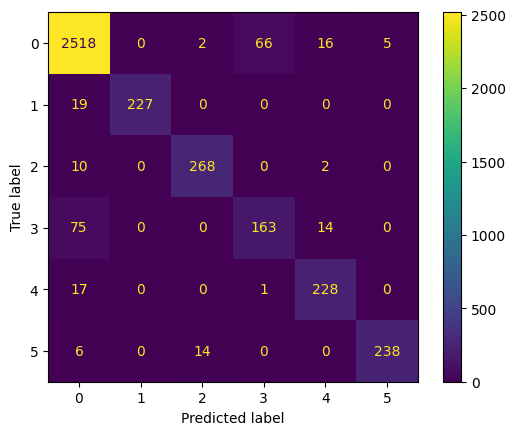

In [50]:
drow_confusion_matrix(bc_hyper)

## ExtraTreeClassifier

In [51]:
from sklearn.tree import ExtraTreeClassifier

etc = ExtraTreeClassifier(random_state=42)

etc.fit(X_train, y_train)

y_pred = etc.predict(X_test)

print(f'Метрики на тестовой выборке \n\
{classification_report(y_test, y_pred)}')

Метрики на тестовой выборке 
              precision    recall  f1-score   support

           0       0.87      0.78      0.82      2607
           1       0.79      0.90      0.84       246
           2       0.58      0.53      0.55       280
           3       0.26      0.47      0.33       252
           4       0.33      0.34      0.33       246
           5       0.82      0.95      0.88       258

    accuracy                           0.73      3889
   macro avg       0.61      0.66      0.63      3889
weighted avg       0.77      0.73      0.74      3889



In [52]:
mean_f1['ExtraTree'] = [
    round(f1_score(y_test, y_pred, average = 'micro'), 3)
    ]

In [53]:
def optuna_etc(trial):
  # задаем пространства поиска гиперпараметров
  criterion = trial.suggest_categorical('criterion', ('gini', 'entropy', 'log_loss'))
  splitter = trial.suggest_categorical('splitter', ('random', 'best'))
  max_depth = trial.suggest_int('max_depth', 2, 30, 1)
  min_samples_split = trial.suggest_int('min_samples_split', 2, 10, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10, 1)
  max_features = trial.suggest_categorical('max_features', ('sqrt', 'log2', None))
  class_weight = trial.suggest_categorical('class_weight', ('balanced', None))
  
  # создаем модель
  model = ExtraTreeClassifier(
    criterion=criterion,
    splitter=splitter,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    max_features=max_features,
    class_weight=class_weight,
    random_state=42
  )
    
  # обучаем модель
  model.fit(X_train, y_train)
  score = f1_score(
    y_test, 
    model.predict(X_test), 
    average = 'micro'
    )
  
  
  return score

# cоздаем объект исследования
study_etc = optuna.create_study(study_name="ExtraTreeClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров:
study_etc.optimize(optuna_etc, n_trials=50)
# Выводим на экран гиперпараметры:
print(f'Наилучшие значения гиперпараметров: {study_etc.best_params}')

[I 2024-05-04 15:45:11,193] A new study created in memory with name: ExtraTreeClassifier
[I 2024-05-04 15:45:11,244] Trial 0 finished with value: 0.7256364103882746 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 16, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.7256364103882746.
[I 2024-05-04 15:45:11,585] Trial 1 finished with value: 0.8086911802519928 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 24, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 1 with value: 0.8086911802519928.
[I 2024-05-04 15:45:11,646] Trial 2 finished with value: 0.40550269992285937 and parameters: {'criterion': 'log_loss', 'splitter': 'random', 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 1 with value: 0.8086911802519928.
[

Наилучшие значения гиперпараметров: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 9, 'max_features': None, 'class_weight': None}


In [54]:
etc_hyper = ExtraTreeClassifier(
    **study_etc.best_params,
    random_state=42 #генерация случайных чисел
)
#Обучаем модель
etc_hyper.fit(X_train, y_train)
#Делаем предсказание класса
y_pred = etc_hyper.predict(X_test)

print(f'Метрики на валидационной выборке \n\
{classification_report(y_test, y_pred)}')

Метрики на валидационной выборке 
              precision    recall  f1-score   support

           0       0.91      0.92      0.91      2607
           1       0.98      0.93      0.95       246
           2       1.00      0.82      0.90       280
           3       0.57      0.65      0.61       252
           4       0.70      0.58      0.64       246
           5       0.75      0.90      0.81       258

    accuracy                           0.87      3889
   macro avg       0.82      0.80      0.80      3889
weighted avg       0.88      0.87      0.87      3889



In [55]:
mean_f1['ExtraTree'].append(round(f1_score(y_test, y_pred, average = 'micro'), 3))

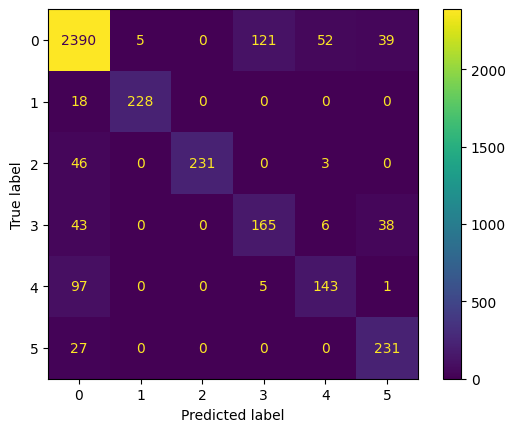

In [56]:
drow_confusion_matrix(etc_hyper)

## ExtraTreeClassifier + BaggingClassifier

In [57]:
etc_bc = BaggingClassifier(
    estimator = etc_hyper,
    **study_bc.best_params,
    random_state=42 #генерация случайных чисел
)
#Обучаем модель
etc_bc.fit(X_train, y_train)
#Делаем предсказание класса
y_pred = etc_bc.predict(X_test)

print(f'Метрики на валидационной выборке \n\
{classification_report(y_test, y_pred)}')

Метрики на валидационной выборке 
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      2607
           1       0.99      0.90      0.94       246
           2       0.95      0.94      0.94       280
           3       0.82      0.37      0.51       252
           4       0.96      0.91      0.94       246
           5       0.96      0.95      0.95       258

    accuracy                           0.93      3889
   macro avg       0.93      0.84      0.87      3889
weighted avg       0.93      0.93      0.92      3889



In [58]:
mean_f1['ExtraTree+Bag'] = [
    round(f1_score(y_test, y_pred, average = 'micro'), 3),
    round(f1_score(y_test, y_pred, average = 'micro'), 3)
    ]

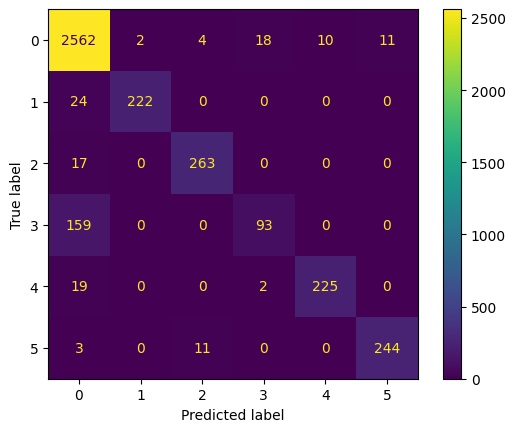

In [59]:
drow_confusion_matrix(etc_bc)

## LinearDiscriminantAnalysis

In [60]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

ldac = LinearDiscriminantAnalysis()

ldac.fit(X_train, y_train)

y_pred = ldac.predict(X_test)

print(f'Метрики на тестовой выборке \n\
{classification_report(y_test, y_pred)}')

Метрики на тестовой выборке 
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2607
           1       0.98      0.96      0.97       246
           2       0.94      0.99      0.96       280
           3       0.83      0.60      0.69       252
           4       0.76      0.95      0.84       246
           5       0.95      0.93      0.94       258

    accuracy                           0.94      3889
   macro avg       0.90      0.90      0.90      3889
weighted avg       0.94      0.94      0.94      3889



In [64]:
mean_f1['LinDiscAn'] = [
    round(f1_score(y_test, y_pred, average = 'micro'), 3),
    round(f1_score(y_test, y_pred, average = 'micro'), 3)
    ]

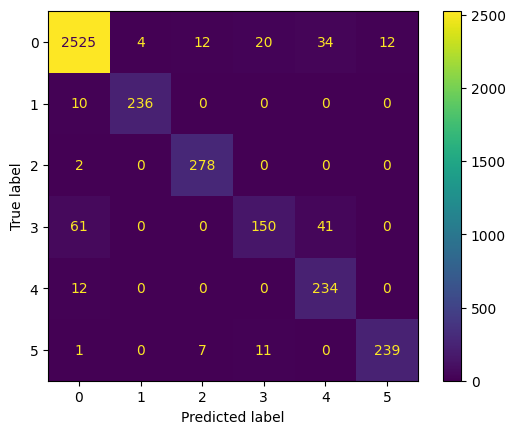

In [65]:
drow_confusion_matrix(ldac)

## Случайный лес

In [67]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print(f'Метрики на валидационной выборке \n\
{classification_report(y_test, y_pred)}')

Метрики на валидационной выборке 
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      2607
           1       0.99      0.94      0.97       246
           2       0.99      0.98      0.98       280
           3       0.78      0.47      0.59       252
           4       0.96      0.92      0.94       246
           5       0.96      1.00      0.98       258

    accuracy                           0.94      3889
   macro avg       0.94      0.88      0.90      3889
weighted avg       0.94      0.94      0.94      3889



In [68]:
mean_f1['RanFor'] = [
    round(f1_score(y_test, y_pred, average = 'micro'), 3)
    ]

In [69]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 50, 500, 10)
  criterion = trial.suggest_categorical('criterion', ('gini', 'entropy', 'log_loss'))
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
  
  # создаем модель
  model = RandomForestClassifier(
    n_estimators=n_estimators,
    criterion=criterion,
    max_depth=max_depth,
    min_samples_leaf=min_samples_leaf,
    random_state=42
    )
  
  # обучаем модель
  model.fit(X_train, y_train)
  score = f1_score(
    y_test, 
    model.predict(X_test), 
    average = 'micro'
    )
  
  return score

# cоздаем объект исследования
study_rf = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров:
study_rf.optimize(optuna_rf, n_trials=50)
# Выводим на экран гиперпараметры:
print(f'Наилучшие значения гиперпараметров: {study_rf.best_params}')

[I 2024-05-04 16:15:33,673] A new study created in memory with name: RandomForestClassifier
[I 2024-05-04 16:15:40,672] Trial 0 finished with value: 0.9421445101568526 and parameters: {'n_estimators': 60, 'criterion': 'entropy', 'max_depth': 19, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9421445101568526.
[I 2024-05-04 16:16:25,093] Trial 1 finished with value: 0.9434301877089226 and parameters: {'n_estimators': 440, 'criterion': 'entropy', 'max_depth': 13, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.9434301877089226.
[I 2024-05-04 16:16:53,320] Trial 2 finished with value: 0.9439444587297505 and parameters: {'n_estimators': 260, 'criterion': 'entropy', 'max_depth': 17, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.9439444587297505.
[I 2024-05-04 16:17:12,763] Trial 3 finished with value: 0.9431730521985087 and parameters: {'n_estimators': 200, 'criterion': 'entropy', 'max_depth': 14, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.9439444587297505.
[

Наилучшие значения гиперпараметров: {'n_estimators': 400, 'criterion': 'log_loss', 'max_depth': 22, 'min_samples_leaf': 7}


In [70]:
rf_hyper = RandomForestClassifier(
    **study_rf.best_params,
    random_state=42 #генерация случайных чисел
)
#Обучаем модель
rf_hyper.fit(X_train, y_train)
#Делаем предсказание класса
y_pred = rf_hyper.predict(X_test)

print(f'Метрики на валидационной выборке \n\
{classification_report(y_test, y_pred)}')

Метрики на валидационной выборке 
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      2607
           1       1.00      0.95      0.97       246
           2       0.99      0.98      0.99       280
           3       0.84      0.46      0.59       252
           4       0.97      0.95      0.96       246
           5       0.96      0.99      0.98       258

    accuracy                           0.95      3889
   macro avg       0.95      0.89      0.91      3889
weighted avg       0.94      0.95      0.94      3889



In [71]:
mean_f1['RanFor'].append(round(f1_score(y_test, y_pred, average = 'micro'), 3))

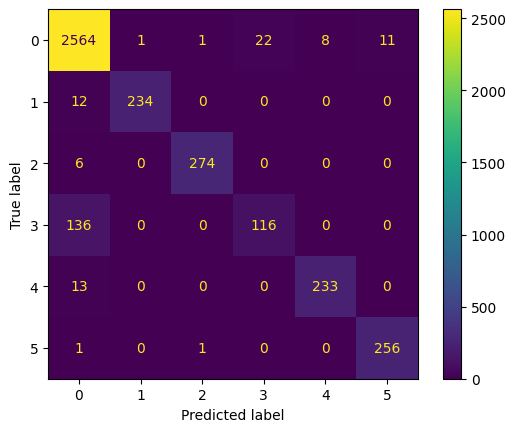

In [72]:
drow_confusion_matrix(rf_hyper)

## Экстремальный градиентный бустинг

In [73]:
from xgboost import XGBClassifier

xbc = XGBClassifier()
xbc.fit(X_train, y_train)

y_pred = xbc.predict(X_test)

print(f'Метрики на валидационной выборке \n\
{classification_report(y_test, y_pred)}')

Метрики на валидационной выборке 
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      2607
           1       0.99      0.96      0.98       246
           2       0.98      0.99      0.98       280
           3       0.50      0.60      0.55       252
           4       0.92      0.96      0.94       246
           5       0.96      0.99      0.97       258

    accuracy                           0.92      3889
   macro avg       0.88      0.90      0.89      3889
weighted avg       0.93      0.92      0.92      3889



In [74]:
mean_f1['XGBC'] = [
    round(f1_score(y_test, y_pred, average = 'micro'), 3)
    ]

In [75]:
def optuna_xbc(trial):
  # задаем пространства поиска гиперпараметров
  min_child_weight = trial.suggest_int('min_child_weight', 1, 50, 1)
  learning_rate = trial.suggest_float(name='learning_rate', low=0.1, high=1.0, step=0.1)
  max_depth = trial.suggest_int('max_depth', 5, 30, 1)
  gamma = trial.suggest_float(name='gamma', low=0, high=0.5, step=0.1)
  subsample = trial.suggest_float(name='subsample', low=0.6, high=1, step=0.05)
  colsample_bytree = trial.suggest_float(name='colsample_bytree', low=0.6, high=1, step=0.05)
  n_estimators = trial.suggest_int('n_estimators', 50, 500, 10)
  
  # создаем модель
  model = XGBClassifier(
    min_child_weight=min_child_weight,
    learning_rate=learning_rate,
    max_depth=max_depth,
    gamma=gamma,
    subsample=subsample,
    colsample_bytree=colsample_bytree,
    n_estimators=n_estimators
    )
  
  # обучаем модель
  model.fit(X_train, y_train)
  score = f1_score(
    y_test, 
    model.predict(X_test), 
    average = 'micro'
    )
  
  
  return score

# cоздаем объект исследования
study_xbc = optuna.create_study(study_name="XGBClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров:
study_xbc.optimize(optuna_xbc, n_trials=50)
# Выводим на экран гиперпараметры:
print(f'Наилучшие значения гиперпараметров: {study_xbc.best_params}')

[I 2024-05-04 16:50:29,575] A new study created in memory with name: XGBClassifier
[I 2024-05-04 16:50:38,083] Trial 0 finished with value: 0.934173309334019 and parameters: {'min_child_weight': 1, 'learning_rate': 0.5, 'max_depth': 12, 'gamma': 0.1, 'subsample': 0.95, 'colsample_bytree': 0.65, 'n_estimators': 450}. Best is trial 0 with value: 0.934173309334019.
[I 2024-05-04 16:50:45,214] Trial 1 finished with value: 0.910773977886346 and parameters: {'min_child_weight': 38, 'learning_rate': 1.0, 'max_depth': 22, 'gamma': 0.30000000000000004, 'subsample': 0.75, 'colsample_bytree': 0.75, 'n_estimators': 300}. Best is trial 0 with value: 0.934173309334019.
[I 2024-05-04 16:50:55,509] Trial 2 finished with value: 0.9264592440215994 and parameters: {'min_child_weight': 20, 'learning_rate': 0.6, 'max_depth': 12, 'gamma': 0.0, 'subsample': 0.6, 'colsample_bytree': 1.0, 'n_estimators': 370}. Best is trial 0 with value: 0.934173309334019.
[I 2024-05-04 16:51:01,877] Trial 3 finished with valu

Наилучшие значения гиперпараметров: {'min_child_weight': 1, 'learning_rate': 0.9, 'max_depth': 18, 'gamma': 0.1, 'subsample': 0.85, 'colsample_bytree': 0.6, 'n_estimators': 100}


In [76]:
xgbc_hyper = XGBClassifier(
    **study_xbc.best_params
)
#Обучаем модель
xgbc_hyper.fit(X_train, y_train)
#Делаем предсказание класса
y_pred = xgbc_hyper.predict(X_test)

print(f'Метрики на валидационной выборке \n\
{classification_report(y_test, y_pred)}')

Метрики на валидационной выборке 
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      2607
           1       0.99      0.95      0.97       246
           2       0.90      0.99      0.94       280
           3       0.79      0.64      0.71       252
           4       0.93      0.91      0.92       246
           5       0.95      1.00      0.97       258

    accuracy                           0.94      3889
   macro avg       0.92      0.91      0.91      3889
weighted avg       0.94      0.94      0.94      3889



In [77]:
mean_f1['XGBC'].append(round(f1_score(y_test, y_pred, average = 'micro'), 3))

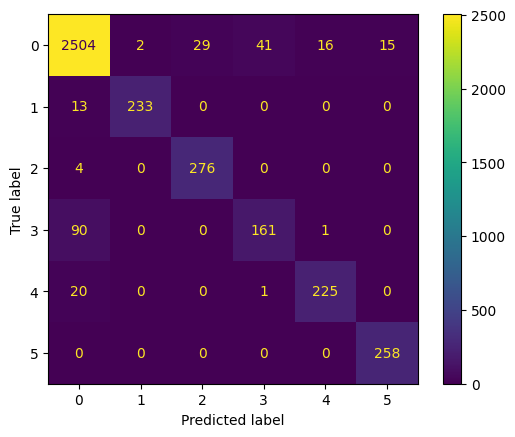

In [78]:
drow_confusion_matrix(xgbc_hyper)

## CatboostClassifier

In [79]:
from catboost import CatBoostClassifier

cbc = CatBoostClassifier(random_state=42, silent=True)
# Train the model on the training data
cbc.fit(X_train, y_train)

y_pred = cbc.predict(X_test)

print(f'Метрики на валидационной выборке \n\
{classification_report(y_test, y_pred)}')

Метрики на валидационной выборке 
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      2607
           1       0.99      0.96      0.98       246
           2       0.96      0.99      0.97       280
           3       0.70      0.60      0.64       252
           4       0.89      0.96      0.92       246
           5       0.95      0.95      0.95       258

    accuracy                           0.94      3889
   macro avg       0.91      0.90      0.90      3889
weighted avg       0.93      0.94      0.93      3889



In [80]:
mean_f1['CBC'] = [
    round(f1_score(y_test, y_pred, average = 'micro'), 3)
    ]

In [81]:
def optuna_cbc(trial):
  # задаем пространства поиска гиперпараметров
  learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1)
  depth = trial.suggest_int('depth', 2, 10)
  colsample_bylevel = trial.suggest_float('colsample_bylevel', 0.1, 1)
  min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 10, 100)
  

  # создаем модель
  model = CatBoostClassifier(
    learning_rate=learning_rate,
    depth=depth,
    colsample_bylevel=colsample_bylevel,
    min_data_in_leaf=min_data_in_leaf,
    silent=True,
    loss_function='MultiClass',
    random_state=42
    )
  # обучаем модель
  model.fit(X_train, y_train)
  score = f1_score(
      y_test, 
      model.predict(X_test), 
      average='micro'
      )

  return score

# cоздаем объект исследования
study_cbc = optuna.create_study(
    study_name="CatBoostClassifier",
    direction="maximize"
    )
# ищем лучшую комбинацию гиперпараметров
study_cbc.optimize(optuna_cbc, n_trials=50)
# Выводим на экран гиперпараметры:
print(f'Наилучшие значения гиперпараметров: {study_cbc.best_params}')

[I 2024-05-04 17:15:56,794] A new study created in memory with name: CatBoostClassifier
[I 2024-05-04 17:16:48,691] Trial 0 finished with value: 0.9262021085111853 and parameters: {'learning_rate': 0.04471511099303486, 'depth': 6, 'colsample_bylevel': 0.5185978489718418, 'min_data_in_leaf': 91}. Best is trial 0 with value: 0.9262021085111853.
[I 2024-05-04 17:29:36,190] Trial 1 finished with value: 0.9390588840318848 and parameters: {'learning_rate': 0.08563120288456773, 'depth': 10, 'colsample_bylevel': 0.8403020996711317, 'min_data_in_leaf': 65}. Best is trial 1 with value: 0.9390588840318848.
[I 2024-05-04 17:29:47,044] Trial 2 finished with value: 0.9262021085111853 and parameters: {'learning_rate': 0.08724471044798464, 'depth': 3, 'colsample_bylevel': 0.13852526728826361, 'min_data_in_leaf': 50}. Best is trial 1 with value: 0.9390588840318848.
[I 2024-05-04 17:30:05,472] Trial 3 finished with value: 0.9022885060426845 and parameters: {'learning_rate': 0.05122756671303325, 'depth':

Наилучшие значения гиперпараметров: {'learning_rate': 0.07330148203533794, 'depth': 9, 'colsample_bylevel': 0.9373363004465494, 'min_data_in_leaf': 39}


In [82]:
cbc_hyper = CatBoostClassifier(
    **study_cbc.best_params,
    silent=True,
    loss_function='MultiClass',
    random_state=42
)
#Обучаем модель
cbc_hyper.fit(X_train, y_train)
#Делаем предсказание класса
y_pred = cbc_hyper.predict(X_test)

print(f'Метрики на тестовой выборке \n\
{classification_report(y_test, y_pred)}')

Метрики на тестовой выборке 
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      2607
           1       0.99      0.96      0.98       246
           2       0.95      0.98      0.97       280
           3       0.79      0.56      0.65       252
           4       0.94      0.96      0.95       246
           5       0.95      0.95      0.95       258

    accuracy                           0.94      3889
   macro avg       0.93      0.90      0.91      3889
weighted avg       0.94      0.94      0.94      3889



In [83]:
mean_f1['CBC'].append(round(f1_score(y_test, y_pred, average = 'micro'), 3))

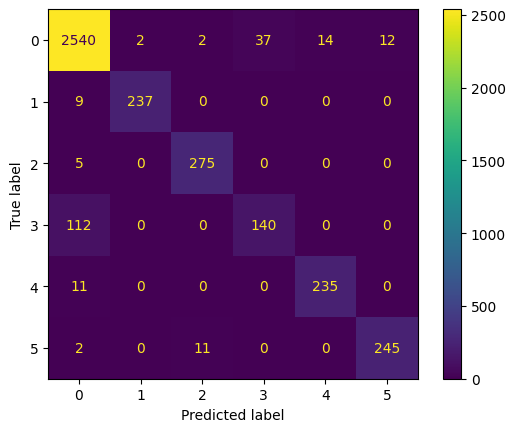

In [84]:
drow_confusion_matrix(cbc_hyper)

Text(0.5, 1.0, 'Тепловая карта значений метрики F1')

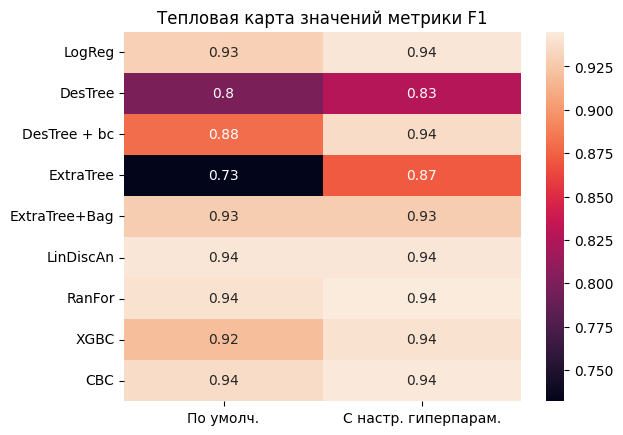

In [85]:
import seaborn as sns

# Визуализируем полученные метрики:
mean_f1_df = pd.DataFrame.from_dict(
    mean_f1, 
    orient='index', 
    columns=['По умолч.', 'С настр. гиперпарам.']
    )
sns.heatmap(mean_f1_df, annot=True)
plt.title('Тепловая карта значений метрики F1')

## Подбор весов классов

In [86]:
log_reg_hyper_cw = LogisticRegression(
    **study_lr.best_params,
    multi_class='auto', #мультиклассовая классификация
    random_state=42,
    class_weight={0: 1, 1: 1, 2: 1, 3: 3, 4: 1, 5: 1}
)
#Обучаем модель
log_reg_hyper_cw.fit(X_train, y_train)
#Делаем предсказание класса
y_pred = log_reg_hyper_cw.predict(X_test)

print(f'Метрики на валидационной выборке \n\
{classification_report(y_test, y_pred)}')

Метрики на валидационной выборке 
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      2607
           1       0.98      0.91      0.95       246
           2       0.92      0.99      0.96       280
           3       0.90      0.75      0.82       252
           4       0.83      0.95      0.89       246
           5       0.95      0.87      0.91       258

    accuracy                           0.95      3889
   macro avg       0.93      0.91      0.91      3889
weighted avg       0.95      0.95      0.95      3889



c:\Users\Олег\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


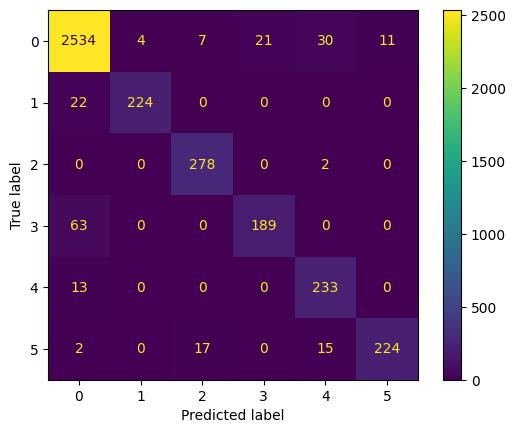

In [87]:
drow_confusion_matrix(log_reg_hyper_cw)

Метрики на валидационной выборке 
              precision    recall  f1-score   support

           0       0.95      0.92      0.94      2607
           1       1.00      0.93      0.96       246
           2       0.94      0.95      0.95       280
           3       0.47      0.64      0.54       252
           4       0.93      0.96      0.94       246
           5       0.98      0.93      0.95       258

    accuracy                           0.91      3889
   macro avg       0.88      0.89      0.88      3889
weighted avg       0.92      0.91      0.91      3889



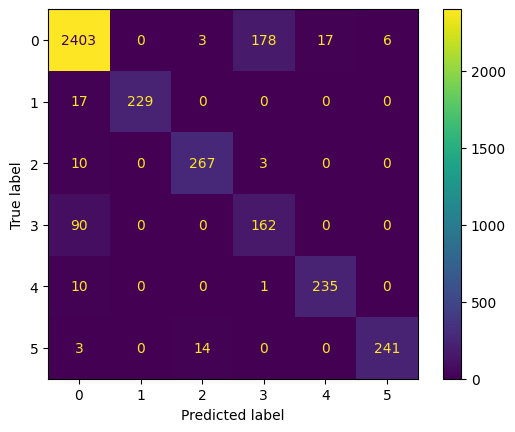

In [92]:
bc_hyper_cw = BaggingClassifier(
    estimator = tree.DecisionTreeClassifier(
    **study_dt.best_params,
    random_state=42,
    class_weight={0: 1, 1: 1, 2: 1, 3: 3, 4: 1, 5: 1}
    ),
    **study_bc.best_params,
    random_state=42 #генерация случайных чисел
)
#Обучаем модель
bc_hyper_cw.fit(X_train, y_train)
#Делаем предсказание класса
y_pred = bc_hyper_cw.predict(X_test)

print(f'Метрики на валидационной выборке \n\
{classification_report(y_test, y_pred)}')

drow_confusion_matrix(bc_hyper_cw)

Метрики на валидационной выборке 
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      2607
           1       1.00      0.90      0.95       246
           2       0.96      0.96      0.96       280
           3       0.77      0.54      0.63       252
           4       0.96      0.89      0.93       246
           5       0.95      0.95      0.95       258

    accuracy                           0.93      3889
   macro avg       0.93      0.87      0.89      3889
weighted avg       0.93      0.93      0.93      3889



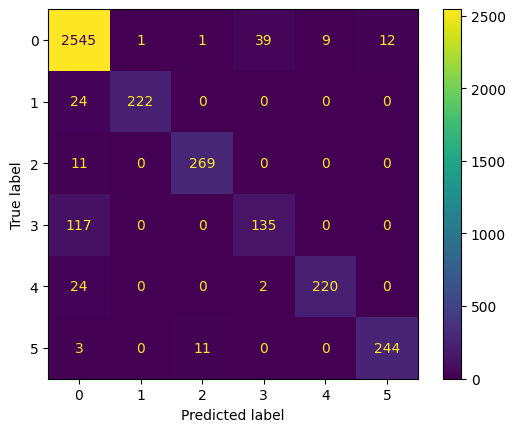

In [94]:
etc_bc_cw = BaggingClassifier(
    estimator = ExtraTreeClassifier(
    criterion='gini',
    splitter='random',
    max_depth=11,
    min_samples_split=3,
    min_samples_leaf=9,
    max_features=None,
    random_state=42,
    class_weight={0: 1, 1: 1, 2: 1, 3: 3, 4: 1, 5: 1}
    ),
    **study_bc.best_params,
    random_state=42 #генерация случайных чисел
)
#Обучаем модель
etc_bc_cw.fit(X_train, y_train)
#Делаем предсказание класса
y_pred = etc_bc_cw.predict(X_test)

print(f'Метрики на валидационной выборке \n\
{classification_report(y_test, y_pred)}')

drow_confusion_matrix(etc_bc_cw)

Метрики на валидационной выборке 
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      2607
           1       1.00      0.95      0.97       246
           2       0.98      0.98      0.98       280
           3       0.74      0.46      0.57       252
           4       0.96      0.95      0.96       246
           5       0.95      0.98      0.97       258

    accuracy                           0.94      3889
   macro avg       0.93      0.88      0.90      3889
weighted avg       0.94      0.94      0.94      3889



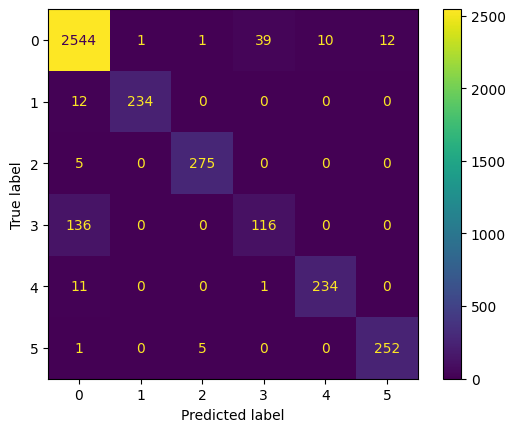

In [99]:
rf_hyper_cw = RandomForestClassifier(
    **study_rf.best_params,
    random_state=42,
    class_weight={0: 1, 1: 1, 2: 1, 3: 3, 4: 1, 5: 1}
)
#Обучаем модель
rf_hyper_cw.fit(X_train, y_train)
#Делаем предсказание класса
y_pred = rf_hyper_cw.predict(X_test)

print(f'Метрики на валидационной выборке \n\
{classification_report(y_test, y_pred)}')

drow_confusion_matrix(rf_hyper_cw)